# Title
COVID19 Global Forecasting (Week2)

## Purpose
This is week 2 of Kaggle's COVID19 forecasting series, following the Week 1 competition. This is the 2nd of at least 4 competitions we plan to launch in this series.

The White House Office of Science and Technology Policy (OSTP) pulled together a coalition research groups and companies (including Kaggle) to prepare the COVID-19 Open Research Dataset (CORD-19) to attempt to address key open scientific questions on COVID-19. Those questions are drawn from National Academies of Sciences, Engineering, and Medicine’s (NASEM) and the World Health Organization (WHO)

# Setup

## Library import
We import all the required Python libraries

In [38]:
# Data Analysis packages
import pandas as pd
pd.set_option('display.max_colwidth', 200)
pd.set_option('display.max_rows', 500) # OR pd.options.display.max_rows = 500
pd.set_option('display.max_columns', 500) # OR pd.options.display.max_columns = 500
import pandas_profiling 
import numpy as np


# Data Visualization packages
import matplotlib.pyplot as plt
plt.rc("font", size=14)
%matplotlib inline
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

# Other useful packages
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
import os
from tqdm import tqdm, tqdm_notebook
from subprocess import check_output
from pydotplus.graphviz import graph_from_dot_data
from graphviz import Source

# Sklearn API
from sklearn import datasets
from sklearn.tree import export_graphviz
from sklearn.pipeline import make_pipeline
from sklearn.externals import joblib

#Common Model Helpers
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn import feature_selection
from sklearn import model_selection
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_validate
from sklearn import metrics


#Importing Regression Models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn import svm


# Regression Algo Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


#Pipeline with Pandas
import pdpipe as pdp

# Stats API
import scipy.stats as stats
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
import statsmodels.formula.api as smf
from scipy.stats import randint as sp_randint


from IPython import get_ipython
ipython = get_ipython()

# If in ipython, load autoreload extension
if 'ipython' in globals():
    print('\nWelcome to IPython!')
    ipython.magic('load_ext autoreload')
    ipython.magic('autoreload 2')

# Display all cell outputs in notebook
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'


print('Your favorite libraries have been loaded.')


Welcome to IPython!
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Your favorite libraries have been loaded.



# Data import
We retrieve all the required data for the analysis.

In [39]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_submission = pd.read_csv('submission.csv')
display(df_train.head())
display(df_test.head())
display(df_submission.head())

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
0,1,NaN,Afghanistan,2020-01-22,0.0,0.0
1,2,NaN,Afghanistan,2020-01-23,0.0,0.0
2,3,NaN,Afghanistan,2020-01-24,0.0,0.0
3,4,NaN,Afghanistan,2020-01-25,0.0,0.0
4,5,NaN,Afghanistan,2020-01-26,0.0,0.0


,ForecastId,Province_State,Country_Region,Date
0,1,NaN,Afghanistan,2020-03-19
1,2,NaN,Afghanistan,2020-03-20
2,3,NaN,Afghanistan,2020-03-21
3,4,NaN,Afghanistan,2020-03-22
4,5,NaN,Afghanistan,2020-03-23


,ForecastId,ConfirmedCases,Fatalities
0,1,1,1
1,2,1,1
2,3,1,1
3,4,1,1
4,5,1,1


In [40]:
print(df_train.shape)
print(df_test.shape)
print(df_submission.shape)

(19698, 6)
(12642, 4)
(12642, 3)


# Data pre-processing


In [41]:
report = pandas_profiling.ProfileReport(df_train)
report.to_file(output_file = 'profilereport.html')

In [42]:
print("Number of Country_Region: ", df_train['Country_Region'].nunique())
print("Dates go from day", max(df_train['Date']), "to day", min(df_train['Date']), ", a total of", df_train['Date'].nunique(), "days")
print("Countries with Province/State informed: ", df_train[df_train['Province_State'].isna()==False]['Country_Region'].unique())


Number of Country_Region:  173
Dates go from day 2020-03-28 to day 2020-01-22 , a total of 67 days
Countries with Province/State informed:  ['Australia' 'Canada' 'China' 'Denmark' 'France' 'Netherlands' 'US'
 'United Kingdom']


Text(0.5, 1.0, 'Global confirmed cases')

Text(0, 0.5, 'Number of cases')

Text(0.5, 0, 'Date')

Text(0.5, 1.0, 'Global deceased cases')

Text(0, 0.5, 'Number of cases')

Text(0.5, 0, 'Date')

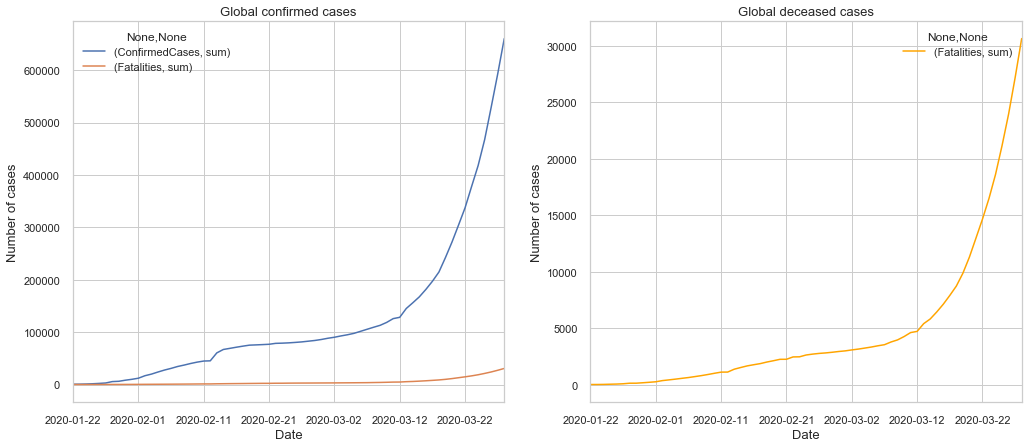

In [43]:
confirmed_total_date = df_train.groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date = df_train.groupby(['Date']).agg({'Fatalities':['sum']})
total_date = confirmed_total_date.join(fatalities_total_date)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,7))
total_date.plot(ax=ax1)
ax1.set_title("Global confirmed cases", size=13)
ax1.set_ylabel("Number of cases", size=13)
ax1.set_xlabel("Date", size=13)
fatalities_total_date.plot(ax=ax2, color='orange')
ax2.set_title("Global deceased cases", size=13)
ax2.set_ylabel("Number of cases", size=13)
ax2.set_xlabel("Date", size=13)

In [25]:
df_train['ConfirmedCases'] = df_train['ConfirmedCases'].astype('int64')

In [28]:
df_train['Fatalities'] = df_train['Fatalities'].astype('int64')

In [16]:
test_Id = df_test.ForecastId
train_Id = df_train.Id
df_train.drop(['Id'], axis=1, inplace=True)
df_test.drop(['ForecastId'], axis=1, inplace=True)

train_index = df_train.shape[0]
test_index = df_test.shape[0]
train_Target1 = df_train.ConfirmedCases
train_Target2 = df_train.Fatalities

all_data = pd.concat((df_train, df_test)).reset_index(drop=True)
all_data.drop([target_col], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (32340, 5)


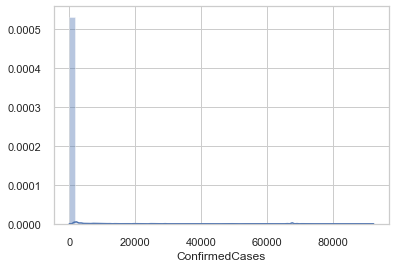

In [17]:
sns.distplot(train_Target1)

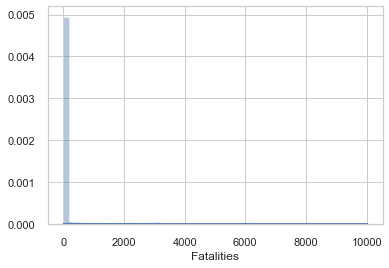

In [18]:
sns.distplot(train_Target2)

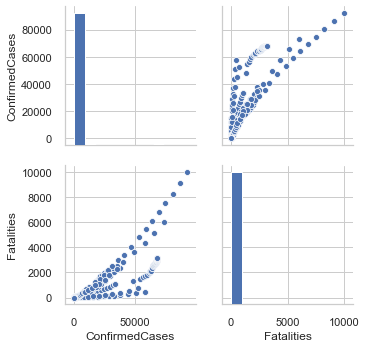

In [31]:
sns.pairplot(df_train)

# Modeling